## Importing libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline


## Load the data

In [6]:
data = pd.read_csv("../../data/fraud_data.csv")
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Check the class imbalance

In [7]:
print("Number of fraud transactions: ", len(data[data['isFraud'] == 1]))
print("Number of non-fraud transactions: ", len(data[data['isFraud'] == 0]))


Number of fraud transactions:  8213
Number of non-fraud transactions:  6354407


In [6]:
fraud_counts_per_customer = data.groupby('nameOrig')['isFraud'].sum().reset_index()
fraud_counts_per_customer.sort_values(by='isFraud', ascending=False).head(10)

,nameOrig,isFraud
886632,C780743034,1
584960,C2131112952,1
176852,C1343086585,1
935335,C87506936,1
28499,C1055498407,1
444340,C1860206969,1
978670,C959116993,1
917986,C841492640,1
253930,C1493011618,1
285344,C1553540945,1


## Drop isFlaggedFraud, step, nameOrig, nameDest

In [7]:
data.drop(['isFlaggedFraud', 'step', 'nameOrig', 'nameDest'], axis=1, inplace=True)


## Prepare the data

In [8]:
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Identify categorical and numerical columns


In [9]:
categorical_columns = ["type"]
numerical_columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]


## Preprocessing

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_columns),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

undersampler = RandomUnderSampler(random_state=42)

classifier = RandomForestClassifier(random_state=42)

k = 7
selector = SelectKBest(score_func=f_classif, k=k)

pipeline = imbPipeline([
    ("preprocessor", preprocessor),
    ("undersampler", undersampler),
    ("selector", selector),
    ("classifier", classifier),
])


# The code below is necessary to get the one-hot encoded feature names after the preprocessing
preprocessor.fit(X)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
transformed_feature_names = numerical_columns + cat_feature_names.tolist()


## Search for best parameters

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["auto", "log2"],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

## Train the model

In [12]:
grid_search.fit(X_train, y_train)


c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['amount',
                                                                          'oldbalanceOrg',
                                                                          'newbalanceOrig',
                                                                          'oldbalanceDest',
                                                                          'newbalanceDest']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['type'])])),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('selector', SelectKBest(k=7)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__max_features': ['auto', 'log2'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1')

### Extract the best hyperparameters and features

In [16]:
print("Best parameters found:", grid_search.best_params_)

selected_features = grid_search.best_estimator_['selector'].get_support(indices=True)
selected_feature_names = [transformed_feature_names[i] for i in selected_features]
selected_feature_names

Best parameters found: {'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


['amount',
 'newbalanceOrig',
 'oldbalanceDest',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_PAYMENT',
 'type_TRANSFER']

## Evaluate the model

Accuracy: 0.988306
Precision: 0.09802408150663786
Recall: 0.9937402190923318
F1 Score: 0.1784459744274273
ROC AUC: 0.9910196326366756
| 7 | 0.9883 | 0.0980 | 0.9937 | 0.1784 | 0.9910 | amount, oldbalanceOrg, newbalanceOrig, type_CASH_IN, type_CASH_OUT, type_PAYMENT, type_TRANSFER |
| 0.9883 | 0.0980 | 0.9937 | 0.1784 | 0.9910 |


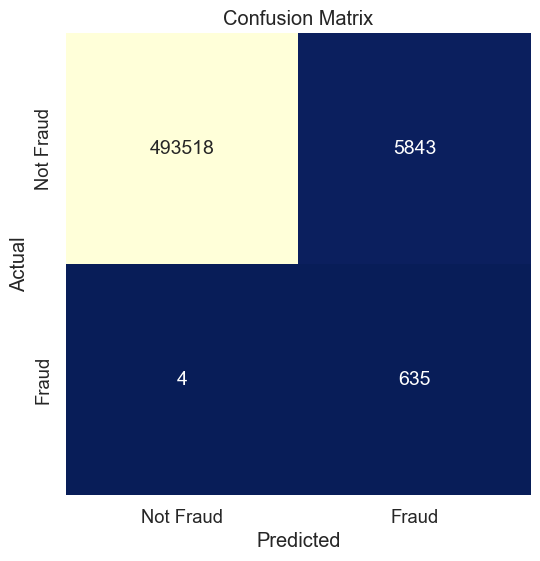

In [ ]:
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='YlGnBu_r', cbar=False, annot_kws={"size": 14},
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
